In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install music21 keras tensorflow

In [ ]:
import glob
import os
import music21
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import math
from pathlib import Path

# Import Keras/TensorFlow
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization, Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import Sequence, to_categorical
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras import mixed_precision

# Import per il processing
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from sklearn.model_selection import train_test_split

# Import per la generazione
from music21 import converter, instrument, note, chord, stream


In [ ]:
from pathlib import Path

data_dir = Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

58416533/58416533 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# --- IMPOSTAZIONI GLOBALI ---
GDRIVE_DATASET_PATH = "/content/drive/MyDrive/maestro-project/Data/maestro-v3.0.0"
LOCAL_DATASET_PATH = "/content/data/maestro-v3.0.0"
PROJECT_PATH = "/content/drive/MyDrive/maestro-project/"
BASE_DIR = "/content/data/maestro-v3.0.0"
METADATA_FILE = os.path.join(LOCAL_DATASET_PATH, "maestro-v3.0.0.csv")
PREPROCESSED_DATA_PATH = os.path.join(PROJECT_PATH, "data_by_song.pkl")
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, "LSTM/best_model-{epoch:02d}-{val_loss:.4f}.keras")

# Seleziona i compositori per lo stile desiderato
COMPOSITORI_SELEZIONATI = ["Frédéric Chopin"]
#COMPOSITORI_SELEZIONATI = ["Frédéric Chopin", "Franz Liszt", "Sergei Rachmaninoff"]




In [ ]:
def process_single_midi(file_info):
    """Processa un singolo file MIDI e restituisce le note estratte."""
    midi_filename, base_dir = file_info
    file_path = os.path.join(base_dir, midi_filename)

    if not os.path.exists(file_path):
        return None # <--- MODIFICA: Restituisce None se il file non esiste

    try:
        midi_file = converter.parse(file_path)
        notes_data = []
        parts = instrument.partitionByInstrument(midi_file)
        notes_parsing = None

        if parts:
            notes_parsing = parts.parts[0].recurse()
        else:
            notes_parsing = midi_file.flat.notes

        for unit in notes_parsing:
            if isinstance(unit, note.Note):
                notes_data.append(str(unit.pitch))
            elif isinstance(unit, chord.Chord):
                notes_data.append('.'.join(str(n) for n in unit.normalOrder))

        return notes_data if notes_data else None # <--- MODIFICA: Restituisce None se non ci sono note

    except Exception as e:
        print(f"Errore nel file {midi_filename}: {e}")
        return None

In [ ]:
def preprocess_and_save_data(chunk_size=None):
    """
    Filtra il dataset per compositore, processa i file MIDI e salva i dati
    come una lista di liste (una lista per ogni brano).
    """
    print("🎵 Avvio elaborazione MIDI...")
    start_time = time.time()

    try:
        metadata = pd.read_csv(METADATA_FILE)
    except FileNotFoundError:
        print(f"❌ ERRORE: File di metadati non trovato in {METADATA_FILE}")
        return None

    metadata_filtrati = metadata[metadata['canonical_composer'].isin(COMPOSITORI_SELEZIONATI)]
    file_midi_da_processare = metadata_filtrati['midi_filename'].tolist()

    print(f"🎼 Trovati {len(file_midi_da_processare)} file per i compositori: {', '.join(COMPOSITORI_SELEZIONATI)}")
    if not file_midi_da_processare:
        return None

    file_info_list = [(filename, BASE_DIR) for filename in file_midi_da_processare]

    # <--- MODIFICA CHIAVE: Questa sarà una lista di liste ---
    all_songs_notes = []

    num_processes = multiprocessing.cpu_count()
    print(f"🚀 Elaborazione parallela con {num_processes} processi...")

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        with tqdm(total=len(file_info_list), desc="Elaborazione file", unit="file") as pbar:
            for notes_from_file in executor.map(process_single_midi, file_info_list):
                # <--- MODIFICA CHIAVE: Aggiunge la lista di note del brano, se non è vuota ---
                if notes_from_file:
                    all_songs_notes.append(notes_from_file)
                pbar.update(1)

    end_time = time.time()
    print(f"\n✅ Elaborazione completata in {end_time - start_time:.2f} secondi.")
    print(f"🎵 Brani totali processati con successo: {len(all_songs_notes)}")

    if all_songs_notes:
        print(f"💾 Salvataggio dati in '{PREPROCESSED_DATA_PATH}'...")
        with open(PREPROCESSED_DATA_PATH, 'wb') as f:
            pickle.dump(all_songs_notes, f)
        print("✅ Dati salvati.")

    return all_songs_notes

In [ ]:
def load_preprocessed_data():
    """Carica i dati pre-elaborati (lista di liste di note)."""
    if not os.path.exists(PREPROCESSED_DATA_PATH):
        print(f"File dati non trovato. Avvio la pre-elaborazione...")
        return preprocess_and_save_data()

    print(f"Caricamento dati da '{PREPROCESSED_DATA_PATH}'...")
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
    print(f"✅ Dati caricati. Trovati {len(data)} brani.")
    return data

In [ ]:
class MusicDataGeneratorBySong(Sequence):
    def __init__(self, data_songs, sequence_length, n_vocab, batch_size, note_to_int, shuffle=True):
        self.data_songs = data_songs
        self.sequence_length = sequence_length
        self.n_vocab = n_vocab
        self.batch_size = batch_size
        self.note_to_int = note_to_int
        self.shuffle = shuffle

        self.indices = []
        for song_idx, song_notes in enumerate(self.data_songs):
            if len(song_notes) > self.sequence_length:
                for i in range(len(song_notes) - self.sequence_length):
                    self.indices.append((song_idx, i))

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_input = []
        batch_output = []

        for song_idx, start_idx in batch_indices:
            song = self.data_songs[song_idx]
            sequence_in = song[start_idx : start_idx + self.sequence_length]
            sequence_out = song[start_idx + self.sequence_length]

            batch_input.append([self.note_to_int.get(char, 0) for char in sequence_in])
            batch_output.append(self.note_to_int.get(sequence_out, 0))

        batch_output_categorical = to_categorical(batch_output, num_classes=self.n_vocab)
        return np.array(batch_input), batch_output_categorical

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
from keras.models import Sequential
from keras.regularizers import l1, l2, l1_l2
from keras.layers import LSTM, Dense, Embedding, Dropout, BatchNormalization, Activation
from keras.optimizers import RMSprop

def create_model(n_vocab, sequence_length=100):
    """
    Crea l'architettura del modello neurale con un layer di Embedding.
    VERSZONE AGGIORNATA per Keras moderno: specifica l'input_shape nel primo layer.
    """
    model = Sequential()

    # Layer 1: Embedding
    # Questo layer trasforma le sequenze di interi (indici delle note) in vettori densi.
    # Impara una rappresentazione vettoriale per ogni nota, catturando le relazioni musicali.
    # - input_dim: Dimensione del vocabolario (il numero totale di note/accordi).
    # - output_dim: La dimensione del vettore che rappresenterà ogni nota (un iperparametro). 512 è un buon valore.
    # - input_shape: La lunghezza di ogni sequenza di input.
    model.add(Embedding(input_dim=n_vocab, output_dim=128, input_shape=(sequence_length,), name='Input_Note_Embedding'))

    #Tabella Riassuntiva
    #Metodo	Dove agisce	Scopo principale
    #model.add(Dropout(0.3))	Sull'output finale del layer LSTM.	Regolarizzare la connessione tra l'LSTM e il layer successivo.
    #dropout=0.3	Sull'input della cella LSTM ad ogni timestep.	Rendere la cella meno dipendente da specifiche feature dell'input ad ogni passo.
    #recurrent_dropout=0.3	Sullo stato nascosto (ricorrente) che passa tra i timestep.	Prevenire l'overfitting sulle dipendenze temporali senza distruggere la memoria.

    # Layer 2, 3: LSTM Stacked
    # Usiamo più layer LSTM per apprendere pattern temporali a diversi livelli di astrazione.
    # 'return_sequences=True' è fondamentale per i layer intermedi,
    # perché passa l'output di ogni timestep al layer successivo, invece del solo output finale.
    model.add(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='LSTM_Local_Patterns'))
    model.add(Dropout(0.2, name='Dropout_1'))
    model.add(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='LSTM_Musical_Phrases'))
    model.add(Dropout(0.2, name='Dropout_2'))

    # Layer 4: Ultimo LSTM
    # Questo layer non ha 'return_sequences=True', quindi restituisce solo l'output dell'ultimo timestep.
    # Questo condensa l'informazione dell'intera sequenza in un singolo vettore di output.
    model.add(LSTM(units=128, name='LSTM_Structural_Summary'))

    # Layer 5: Dense Intermedio
    # Un layer denso per processare l'output dell'LSTM prima della classificazione finale.
    # La BatchNormalization aiuta a stabilizzare e accelerare il training.
    model.add(Dense(128, name='Dense_Feature_Processing'))
    model.add(BatchNormalization(name='BatchNorm_Stabilizer'))
    model.add(Activation('relu', name='ReLU_Activation'))
    model.add(Dropout(0.2, name='Dropout_3'))

    # Layer 6: Output Layer
    # Questo è il layer di output finale. Deve avere un numero di neuroni pari alla dimensione del vocabolario.
    # L'attivazione 'softmax' trasforma l'output in una distribuzione di probabilità: ogni neurone
    # rappresenterà la probabilità che la nota corrispondente sia la successiva nella sequenza.
    model.add(Dense(n_vocab, name='Output_Probability_Layer'))
    model.add(Activation('softmax', name='Softmax_Output_Activation'))

    # Compilazione del Modello
    # - loss: 'categorical_crossentropy' è la funzione di perdita corretta per questo tipo di problema
    #   di classificazione multi-classe con output one-hot-encoded.
    # - optimizer: 'rmsprop' è un ottimizzatore robusto che funziona bene con le reti ricorrenti.
    custom_optimizer = RMSprop(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

    return model

In [ ]:
def sample_with_temperature_and_top_k(predictions, temperature=1.0, top_k=50):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)

    if top_k > 0:
        top_k_indices = np.argsort(predictions)[-top_k:]
        mask = np.zeros_like(predictions)
        mask[top_k_indices] = 1
        predictions = predictions * mask
        predictions = predictions / np.sum(predictions)

    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)


In [ ]:
def generate_music(model, all_songs_data, n_vocab, output_length=500, temperature=1.0, top_k=50):
    flat_notes = [note for song in all_songs_data for note in song]
    pitchnames = sorted(set(flat_notes))
    note_to_int = {note: i for i, note in enumerate(pitchnames)}
    int_to_note = {i: note for note, i in note_to_int.items()}

    sequence_length = model.input_shape[1]

    # Scegli una sequenza di seed casuale da tutti i dati
    start_index = np.random.randint(0, len(flat_notes) - sequence_length - 1)
    seed_sequence = flat_notes[start_index : start_index + sequence_length]
    input_sequence = [note_to_int[note] for note in seed_sequence]

    generated_notes = []
    print(f"Generazione musica con T={temperature}, top_k={top_k}...")

    for i in tqdm(range(output_length), desc="Generazione note"):
        # <--- CORREZIONE CRITICA: La forma dell'input deve essere (batch, sequence_length) ---
        input_data = np.reshape(input_sequence, (1, sequence_length))

        predicted_probs = model.predict(input_data, verbose=0)[0]
        predicted_index = sample_with_temperature_and_top_k(predicted_probs, temperature, top_k)
        predicted_note = int_to_note[predicted_index]

        generated_notes.append(predicted_note)
        input_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]

    # Convert to MIDI
    output_stream = stream.Stream()
    for pattern in generated_notes:
        if '.' in pattern or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            output_stream.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.storedInstrument = instrument.Piano()
            output_stream.append(new_note)

    output_path = 'generated_music.mid'
    output_stream.write('midi', fp=output_path)
    print(f"\n✅ Musica generata e salvata come '{output_path}'")

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

# 1. Carica i dati (o li processa se non esistono)
all_songs_notes = load_preprocessed_data()

Caricamento dati da '/content/drive/MyDrive/maestro-project/data_by_song.pkl'...
✅ Dati caricati. Trovati 201 brani.


In [ ]:
if all_songs_notes:
        # <--- MODIFICA: Nuova logica per preparare i dati ---

        # 2. Crea il vocabolario e i dizionari di mapping
  print("Creazione del vocabolario...")
  flat_notes = [note for song in all_songs_notes for note in song]
  pitchnames = sorted(set(flat_notes))
  n_vocab = len(pitchnames)
  note_to_int = {note: i for i, note in enumerate(pitchnames)}
  print(f"Dimensione del vocabolario: {n_vocab} note/accordi unici.")

        # 3. Definisci i parametri
  sequence_length = 100
  batch_size = 512

        # 4. Suddividi i BRANI in set di training e validazione
  print("Suddivisione dei brani in set di training e validazione...")
  train_songs, val_songs = train_test_split(all_songs_notes, test_size=0.15, random_state=42)
  print(f"Numero di brani per training: {len(train_songs)}")
  print(f"Numero di brani per validazione: {len(val_songs)}")

        # 5. Crea i generatori di dati
  train_generator = MusicDataGeneratorBySong(
      train_songs, sequence_length, n_vocab, batch_size, note_to_int
      )
  val_generator = MusicDataGeneratorBySong(
      val_songs, sequence_length, n_vocab, batch_size, note_to_int, shuffle=False
      )

Creazione del vocabolario...
Dimensione del vocabolario: 2004 note/accordi unici.
Suddivisione dei brani in set di training e validazione...
Numero di brani per training: 170
Numero di brani per validazione: 31


In [ ]:
       # 6. Crea il modello
model = create_model(n_vocab, sequence_length)
        # Se vuoi continuare un addestramento:
        # model = load_model('percorso/al/tuo/modello.keras')
model.summary()
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora la stessa metrica del checkpoint!
    patience=10,
    verbose=1,           # Stampa un messaggio quando si ferma.
    mode='min',          # Come prima, la 'val_loss' deve scendere
    restore_best_weights=True
)

        # 7. Definisci i callbacks
checkpoint = ModelCheckpoint(
            CHECKPOINT_PATH,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
        )
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
callbacks_list = [checkpoint, lr_scheduler, early_stopping]

        # 8. Addestra il modello
print("\n--- Inizio Addestramento ---")
history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=150,
            callbacks=callbacks_list,
            verbose=1
        )
print("\n--- Addestramento Completato ---")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Note_Embedding            │ (None, 100, 128)       │       256,512 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Local_Patterns (LSTM)      │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Musical_Phrases (LSTM)     │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Structural_Summary (LSTM)  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Feature_Processing        │ (None, 256)            │        65,792 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Stabilizer            │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU_Activation (Activation)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Probability_Layer        │ (None, 2004)           │       515,028 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax_Output_Activation       │ (None, 2004)           │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,220 (8.71 MB)

 Trainable params: 2,282,708 (8.71 MB)

 Non-trainable params: 512 (2.00 KB)


--- Inizio Addestramento ---
Epoch 1/150
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.0157 - loss: 6.2221
Epoch 1: val_loss improved from inf to 10.58826, saving model to /content/drive/MyDrive/maestro-project/LSTM/best_model-01-10.5883.keras
807/807 ━━━━━━━━━━━━━━━━━━━━ 543s 663ms/step - accuracy: 0.0157 - loss: 6.2214 - val_accuracy: 0.0108 - val_loss: 10.5883 - learning_rate: 0.0030
Epoch 2/150
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.0301 - loss: 5.2424
Epoch 2: val_loss did not improve from 10.58826
807/807 ━━━━━━━━━━━━━━━━━━━━ 531s 658ms/step - accuracy: 0.0301 - loss: 5.2424 - val_accuracy: 0.0067 - val_loss: 14.8587 - learning_rate: 0.0030
Epoch 3/150
  8/807 ━━━━━━━━━━━━━━━━━━━━ 10:13 768ms/step - accuracy: 0.0403 - loss: 5.1479

KeyboardInterrupt: 

### Visualizzazione Grafica delle Metriche di Addestramento

Questo script crea dei grafici per visualizzare l'andamento della loss e dell'accuracy (sia per il training che per la validazione) durante le epoche di addestramento del modello.

In [ ]:
import matplotlib.pyplot as plt

if 'history' in locals() and history is not None:
    print("Generazione grafici delle metriche di addestramento...")

    # Grafico della Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Andamento della Loss durante l\'Addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Grafico dell'Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Andamento dell\'Accuracy durante l\'Addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Oggetto 'history' non trovato. Assicurati che l'addestramento del modello sia stato completato.")

Oggetto 'history' non trovato. Assicurati che l'addestramento del modello sia stato completato.


In [ ]:
# Stampa le chiavi disponibili nell'oggetto history
print("Chiavi disponibili nell'history:", history.history.keys())

# Stampa le metriche di loss e accuracy per training e validazione
print("\nMetriche di Addestramento:")
for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch+1}:")
    print(f"  Loss (Training): {history.history['loss'][epoch]:.4f}")
    print(f"  Accuracy (Training): {history.history['accuracy'][epoch]:.4f}")
    if 'val_loss' in history.history:
        print(f"  Loss (Validazione): {history.history['val_loss'][epoch]:.4f}")
    if 'val_accuracy' in history.history:
        print(f"  Accuracy (Validazione): {history.history['val_accuracy'][epoch]:.4f}")

NameError: name 'history' is not defined

###Generazione Output
generazione del file midi e conversione in wav

In [ ]:
#model = load_model(CHECKPOINT_PATH)
print("\nGenerazione di un campione musicale...")
generate_music(model, all_songs_notes, n_vocab, output_length=75, temperature=1.4, top_k=100)


Generazione di un campione musicale...
Generazione musica con T=1.4, top_k=100...


Generazione note:   1%|▏         | 1/75 [00:00<00:13,  5.61it/s]/tmp/ipython-input-3764657982.py:3: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(predictions) / temperature
Generazione note: 100%|██████████| 75/75 [00:14<00:00,  5.24it/s]



✅ Musica generata e salvata come 'generated_music.mid'


In [ ]:
!pip install midi2audio
!sudo apt install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
from midi2audio import FluidSynth
from IPython.display import Audio

# Chuyển MIDI sang WAV
fs = FluidSynth()
fs.midi_to_audio('generated_music.mid', 'output.wav')

# Phát WAV file
Audio('output.wav')

In [ ]:
# Carica un file MIDI di esempio
# Puoi cambiare questo percorso con il file MIDI che vuoi analizzare
midi_file_path = '/content/generated_music.mid' # Usa il file generato precedentemente

try:
    midi_stream = converter.parse(midi_file_path)
    print(f"File MIDI caricato con successo: {midi_file_path}")
except Exception as e:
    print(f"Errore nel caricamento del file MIDI: {e}")
    midi_stream = None

File MIDI caricato con successo: /content/generated_music.mid


Estratti 75 note/accordi totali dal file MIDI.
Estratti 32 accordi dal file MIDI.

Prime 20 note/accordi più frequenti (generale):


/usr/local/lib/python3.12/dist-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


F#4            4
F4.G#4         4
C#4            3
F#3            3
F4             3
G#2            3
E-4.G#4        3
C4.E-4         3
G#4            3
F5             2
F#4.B-4        2
B-4.C#4        2
E-6            2
C#5            2
E-3            2
C#4.F4         2
G#5            2
B-4.C#4.E-4    1
C#4.E-4        1
E-2            1
Name: count, dtype: int64


Distribuzione degli accordi:


F4.G#4         4
E-4.G#4        3
C4.E-4         3
F#4.B-4        2
C#4.F4         2
B-4.C#4        2
E-4.G4         1
B-4.B4         1
B-4.C#4.E-4    1
C#4.E-4        1
E-4.F4         1
F4.G#4.B-4     1
C4.C#4         1
F4.B4          1
F#4.B-4.C#4    1
C#4.F#4        1
G#4.C4         1
C#4.E-4.G4     1
G#4.C#4        1
C4.F#4         1
F#4.G#4        1
G#4.B4         1
Name: count, dtype: int64

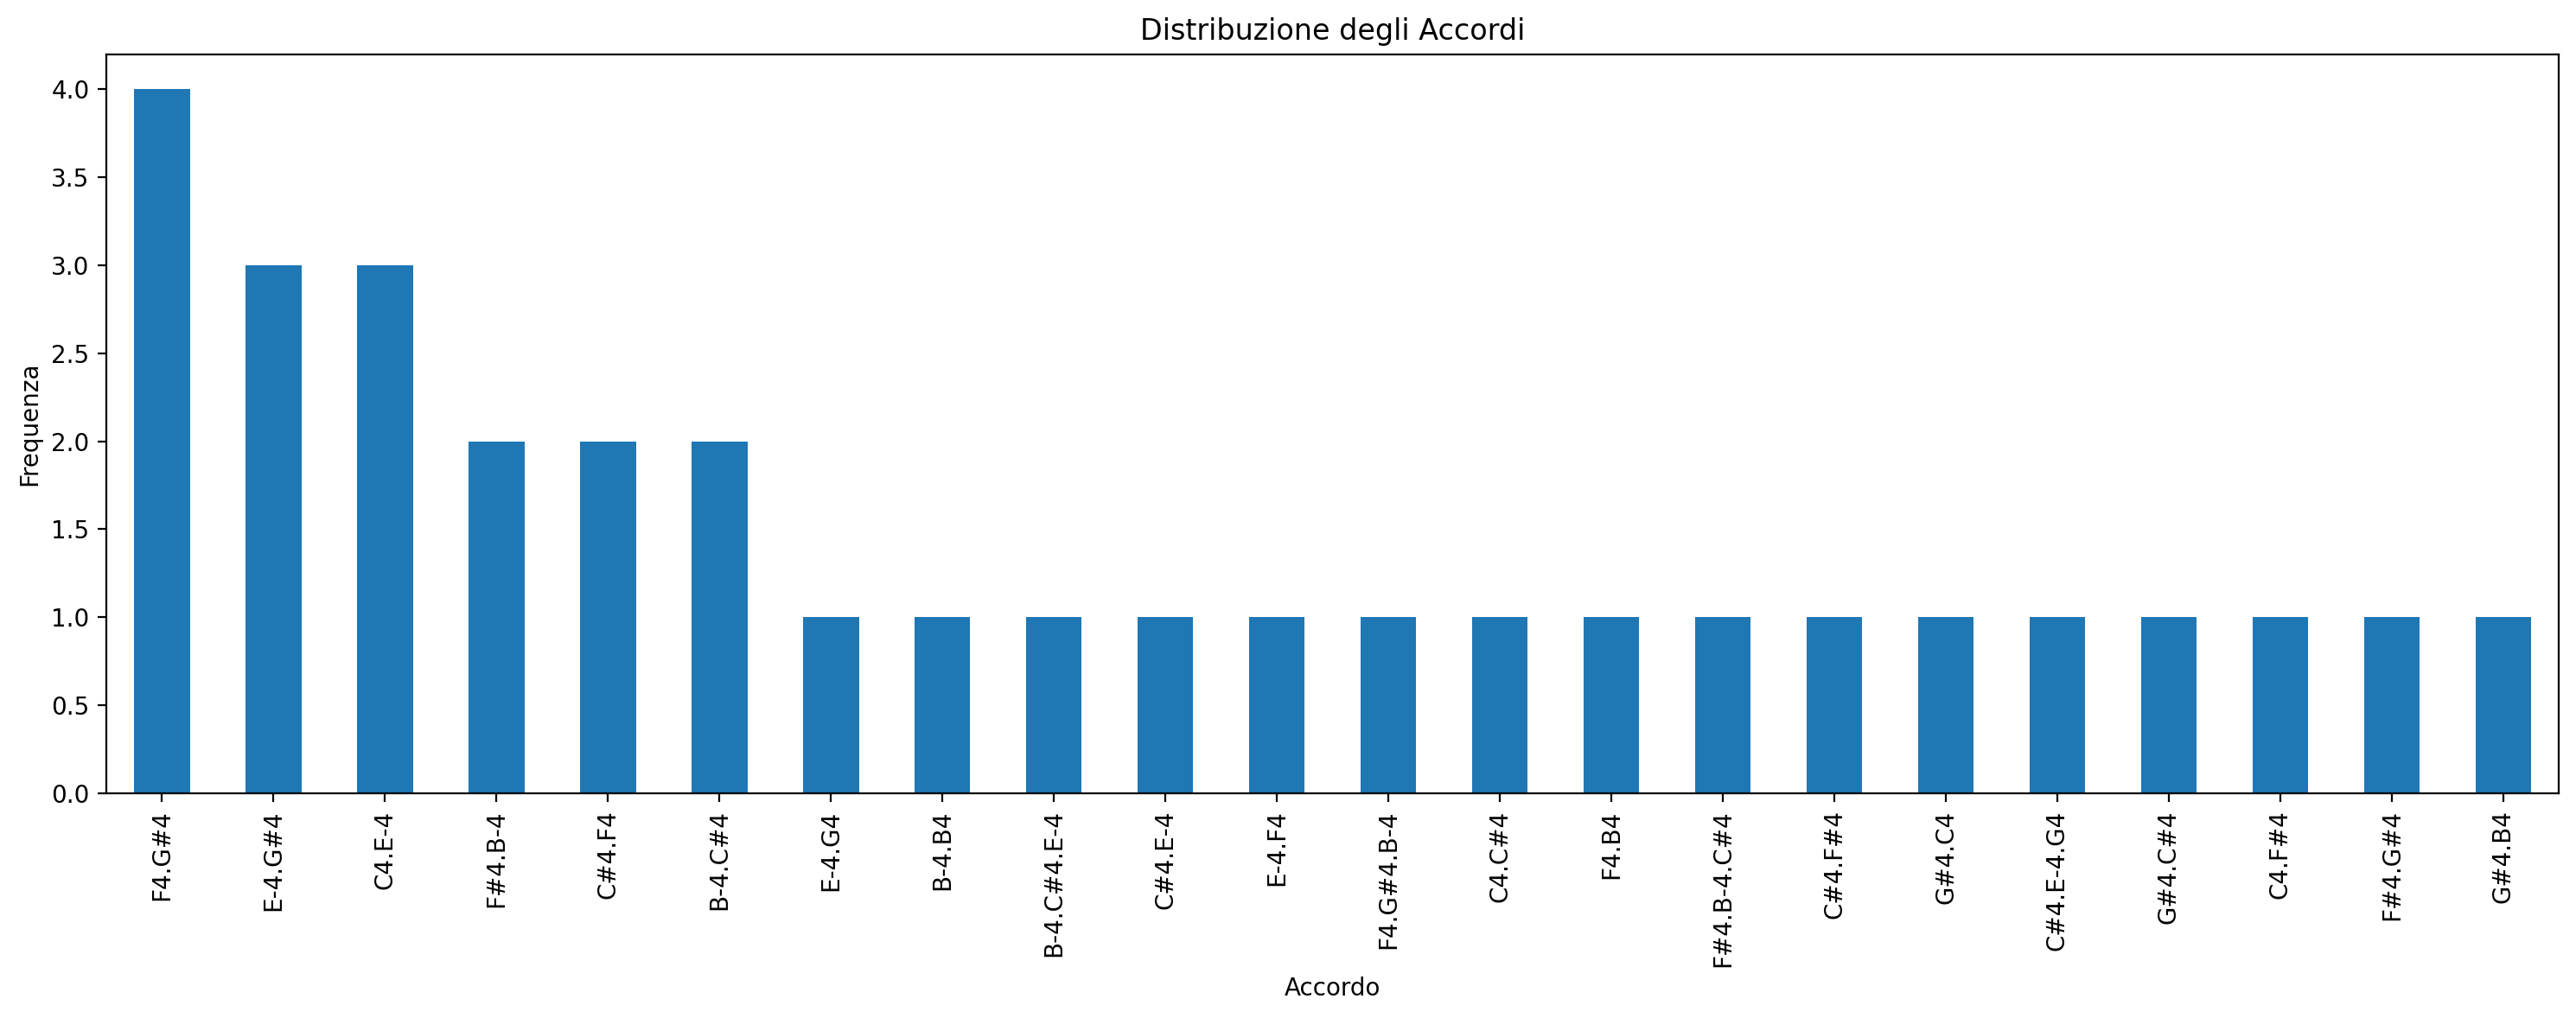

In [ ]:
if midi_stream:
    # Estrai note e accordi
    notes_to_parse = midi_stream.flat.notesAndRests

    notes_list = []
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes_list.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes_list.append('.'.join(str(n.pitch) for n in element.notes)) # Rappresentazione degli accordi

    print(f"Estratti {len(notes_list)} note/accordi dal file MIDI.")

    # Conta la frequenza di ogni nota/accordo
    note_counts = pd.Series(notes_list).value_counts()

    print("\nPrime 20 note/accordi più frequenti:")
    display(note_counts.head(20))

    # Crea un grafico a barre delle note/accordi più frequenti
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 6))
    note_counts.head(50).plot(kind='bar') # Visualizza le prime 50 per chiarezza
    plt.title('Distribuzione delle Note e degli Accordi')
    plt.xlabel('Nota o Accordo')
    plt.ylabel('Frequenza')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

else:
    print("Impossibile procedere con l'analisi senza un file MIDI caricato.")